-----------
## In this notebook:
* Filter out QUEE rows
* Create testing/training/validation DFs
* Copy images into respective folders
-----------

In [48]:
import pandas as pd
import numpy as np
import cv2
import os
import glob
import multiprocessing
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")

## Load Precip DF

In [2]:
day_precip_df = pd.read_pickle("../DFs/day_precip_df.pkl")

In [ ]:
day_precip_df

## Create QUEE Precip Testing/Valid Subset

In [3]:
df_QUEE = day_precip_df.loc[day_precip_df['station']==b'QUEE']

In [4]:
# change index
df_QUEE['index'] = list(range(0,len(df_QUEE)))

In [ ]:
df_QUEE

In [5]:
df_QUEE.loc[df_QUEE['time_5M']=='2020-01-03 10:00:00']

,index,station,time_5M,tair,ta9m,precip,precip_total,precip_max_intensity,snow_depth,precip_diff,img_path,is_day
1668109,6911,b'QUEE',2020-01-03 10:00:00,7.24962,NaN,0.480011,378.420013,0.0,0.002577,0.23999,/tf/NYSM/archive/nysm/cam_photos/2020/01/03/QU...,True


In [6]:
# create a df with images up to 2019 (save 2020 for testing)
df_QUEE_2019 = df_QUEE[(df_QUEE['time_5M'] < '2020-01-03 10:00:00')]

In [7]:
# create a df with just the images
df_QUEE_2019_WP_imgs = df_QUEE_2019['img_path']
df_QUEE_2019_WP_imgs

508647     /tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
508648     /tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
508649     /tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
508650     /tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
508651     /tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
                                 ...                        
1620192    /tf/NYSM/archive/nysm/cam_photos/2019/12/30/QU...
1620193    /tf/NYSM/archive/nysm/cam_photos/2019/12/30/QU...
1620194    /tf/NYSM/archive/nysm/cam_photos/2019/12/30/QU...
1620195    /tf/NYSM/archive/nysm/cam_photos/2019/12/30/QU...
1620196    /tf/NYSM/archive/nysm/cam_photos/2019/12/30/QU...
Name: img_path, Length: 6911, dtype: object

In [ ]:
len(df_QUEE_2019)

In [5]:
# create a df with images 2020+
df_QUEE_2020 = df_QUEE[(df_QUEE['time_5M'] > '2020-01-03 10:00:00')]

#len(df_QUEE_2020)
#df_QUEE_2020['img_path'].iloc[456]

In [23]:
df_QUEE_2020[df_QUEE_2020['precip_diff']==np.max(df_QUEE_2020['precip_diff'])]

,index,station,time_5M,tair,ta9m,precip,precip_total,precip_max_intensity,snow_depth,precip_diff,img_path,is_day
1901302,955,b'QUEE',2020-08-01,25.608931,NaN,23.799995,142.509995,0.0,NaN,23.799995,/tf/NYSM/archive/nysm/cam_photos/2020/08/01/QU...,True


In [21]:
# change index
df_QUEE_2020['index'] = list(range(0,len(df_QUEE_2020)))

In [47]:
df_QUEE_2020['img_path'].iloc[25]

'/tf/NYSM/archive/nysm/cam_photos/2020/01/18/QUEE/20200118T211028_QUEE.jpg'

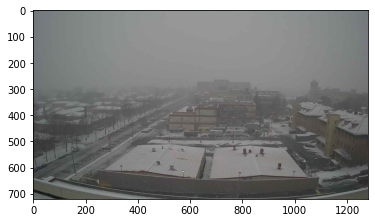

In [46]:
img = mpimg.imread(df_QUEE_2020['img_path'].iloc[25])
plt.imshow(img)

plt.show()

## Copy WP images to respective folder

df_QUEE_2019_WP_imgs.iloc[0]

In [ ]:
destination = "/tf/kokamura/Precip/QUEE-2cl/WP"
os.symlink(df_QUEE_2019_WP_imgs.iloc[0], destination)

In [9]:
# copy images into no precip folder
destination = "/tf/kokamura/Precip/3st-2cl/WP"
for image in df_QUEE_2019_WP_imgs:
    shutil.copy(image, destination)

#### Potentially learn how to use os.symlink when using more images

----------
## Load No Precip DF

In [6]:
no_precip_df_images = pd.read_pickle("../DFs/no_precip_df_images.pkl")

## Create Subset

In [7]:
# create QUEE subset
NP_df_QUEE = no_precip_df_images.loc[no_precip_df_images['station']==b'QUEE']

In [ ]:
len(NP_df_QUEE)

In [ ]:
NP_df_QUEE

In [12]:
# define functions

# determine day images
def is_day(path):
    image = cv2.imread(path)
    b,g,r = image[:,:,0], image[:,:,1], image[:,:,2]
    if (b==g).all() and (b==r).all(): return None
    else: return True
    
# filter out day images
def loopy_d(df):
    output2_df = df.copy()
    output2_df['is_day'] = output2_df['img_path'].apply(
        lambda x: is_day(x)
    )
    return output2_df

In [ ]:
# filter out day images
NUM_CORES = 10
df_chunks = np.array_split(NP_df_QUEE, NUM_CORES)

with multiprocessing.Pool(NUM_CORES) as pool:
    no_df_QUEE = pd.concat(pool.map(loopy_d, df_chunks), ignore_index = True)

In [ ]:
no_df_QUEE['is_day'].isnull().sum()

In [ ]:
QUEE_no_df = no_df_QUEE.loc[no_df_QUEE['is_day'].notnull()]
QUEE_no_df

## Sanity Check

In [13]:
# change index
NP_df_QUEE['index'] = list(range(0,len(NP_df_QUEE)))
NP_df_QUEE

,index,station,time_5M,tair,ta9m,precip,precip_total,precip_max_intensity,snow_depth,precip_diff,img_path
13415687,0,b'QUEE',2017-10-29 01:00:00,17.715380,NaN,0.000000,194.830002,0.0,0.000835,0.0,/tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
13415699,1,b'QUEE',2017-10-29 02:00:00,17.575270,NaN,0.000000,194.830002,0.0,0.001233,0.0,/tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
13415710,2,b'QUEE',2017-10-29 03:00:00,17.936840,NaN,0.050003,194.880005,0.0,0.000205,0.0,/tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
13415721,3,b'QUEE',2017-10-29 04:00:00,17.845510,NaN,0.099991,194.929993,0.0,0.000465,0.0,/tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
13415733,4,b'QUEE',2017-10-29 05:00:00,17.855841,NaN,0.099991,194.929993,0.0,0.000435,0.0,/tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
...,...,...,...,...,...,...,...,...,...,...,...
51615387,185082,b'QUEE',2020-12-31 22:25:00,4.928528,NaN,13.939987,153.929993,0.0,-0.006747,0.0,/tf/NYSM/archive/nysm/cam_photos/2020/12/31/QU...
51615388,185083,b'QUEE',2020-12-31 22:30:00,4.929366,NaN,13.939987,153.929993,0.0,-0.006750,0.0,/tf/NYSM/archive/nysm/cam_photos/2020/12/31/QU...
51615389,185084,b'QUEE',2020-12-31 22:35:00,4.933015,NaN,13.939987,153.929993,0.0,-0.003734,0.0,/tf/NYSM/archive/nysm/cam_photos/2020/12/31/QU...
51615390,185085,b'QUEE',2020-12-31 22:40:00,4.925432,NaN,13.939987,153.929993,0.0,-0.006738,0.0,/tf/NYSM/archive/nysm/cam_photos/2020/12/31/QU...


In [ ]:
NP_df_QUEE['img_path'].iloc[567]

In [ ]:
img = mpimg.imread(NP_df_QUEE['img_path'].iloc[567])
plt.imshow(img)

plt.show()

In [ ]:
len(QUEE_no_df)

## Create QUEE NP Testing/Valid Subset

In [ ]:
NP_QUEE_df.iloc[121833]

In [14]:
# create a df with images up to 2019 (save 2020 for testing)
NP_QUEE_df_2019 = NP_df_QUEE[(NP_df_QUEE['time_5M'] < '2020-01-01 00:00:00')]

In [ ]:
NP_QUEE_df_2019

In [15]:
# create a df with just the images
NP_df_QUEE_2019_imgs = NP_QUEE_df_2019['img_path']
NP_df_QUEE_2019_imgs

13415687    /tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
13415699    /tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
13415710    /tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
13415721    /tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
13415733    /tf/NYSM/archive/nysm/cam_photos/2017/10/29/QU...
                                  ...                        
39382267    /tf/NYSM/archive/nysm/cam_photos/2019/12/31/QU...
39382268    /tf/NYSM/archive/nysm/cam_photos/2019/12/31/QU...
39382269    /tf/NYSM/archive/nysm/cam_photos/2019/12/31/QU...
39382270    /tf/NYSM/archive/nysm/cam_photos/2019/12/31/QU...
39382274    /tf/NYSM/archive/nysm/cam_photos/2019/12/31/QU...
Name: img_path, Length: 121833, dtype: object

## Copy NP images to respective folder

In [ ]:
6911/(6911 + 121833) # only 5% of all images contain precipitation

In [16]:
# chose 7,000 random images to copy over to NP folder
NP_QUEE_img_sample = NP_df_QUEE_2019_imgs.sample(7000, random_state=1)

In [17]:
# copy images into no precip folder
destination = "/tf/kokamura/Precip/3st-2cl/NP"
for image in NP_QUEE_img_sample:
    shutil.copy(image, destination)